In [ ]:
!pip install torch lerobot

In [ ]:
!pip install lerobot.data

In [ ]:
!pip install decord

## Training

In [1]:
# Add parent directory to path to import train module
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))
from train import train

print("\nStarting training process...")
print("Note: We'll use a public dataset for training as our sample is too small")

# Create a temporary directory for training output
train_output_dir = Path('model_output')

print(f"Training output will be saved to: {train_output_dir}")

train(output_dir=str(train_output_dir), dataset_id="ISdept/piper_arm")

/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Starting training process...
Note: We'll use a public dataset for training as our sample is too small
Training output will be saved to: model_output


Fetching 49 files: 100%|██████████| 49/49 [00:00<00:00, 2482.29it/s]


input_features: {'observation.state': PolicyFeature(type=<FeatureType.STATE: 'STATE'>, shape=(7,)), 'observation.images.gripper': PolicyFeature(type=<FeatureType.VISUAL: 'VISUAL'>, shape=(3, 400, 640)), 'observation.images.depth': PolicyFeature(type=<FeatureType.VISUAL: 'VISUAL'>, shape=(3, 400, 640)), 'observation.images.rgb': PolicyFeature(type=<FeatureType.VISUAL: 'VISUAL'>, shape=(3, 400, 640))}
output_features: {'action': PolicyFeature(type=<FeatureType.ACTION: 'ACTION'>, shape=(7,))}


Training Step 0:   0%|          | 0/9196 [00:01<?, ?it/s]


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/lerobot/datasets/lerobot_dataset.py", line 1002, in __getitem__
    video_frames = self._query_videos(query_timestamps, ep_idx)
  File "/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/lerobot/datasets/lerobot_dataset.py", line 967, in _query_videos
    frames = decode_video_frames(video_path, shifted_query_ts, self.tolerance_s, self.video_backend)
  File "/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/lerobot/datasets/video_utils.py", line 69, in decode_video_frames
    return decode_video_frames_torchcodec(video_path, timestamps, tolerance_s)
  File "/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/lerobot/datasets/video_utils.py", line 248, in decode_video_frames_torchcodec
    decoder = decoder_cache.get_decoder(str(video_path))
  File "/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/lerobot/datasets/video_utils.py", line 184, in get_decoder
    from torchcodec.decoders import VideoDecoder
  File "/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/torchcodec/__init__.py", line 10, in <module>
    from . import decoders, samplers  # noqa
  File "/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/torchcodec/decoders/__init__.py", line 7, in <module>
    from .._core import AudioStreamMetadata, VideoStreamMetadata
  File "/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/torchcodec/_core/__init__.py", line 8, in <module>
    from ._metadata import (
  File "/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/torchcodec/_core/_metadata.py", line 16, in <module>
    from torchcodec._core.ops import (
  File "/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/torchcodec/_core/ops.py", line 84, in <module>
    load_torchcodec_shared_libraries()
  File "/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/torchcodec/_core/ops.py", line 69, in load_torchcodec_shared_libraries
    raise RuntimeError(
RuntimeError: Could not load libtorchcodec. Likely causes:
          1. FFmpeg is not properly installed in your environment. We support
             versions 4, 5, 6 and 7.
          2. The PyTorch version (2.7.1) is not compatible with
             this version of TorchCodec. Refer to the version compatibility
             table:
             https://github.com/pytorch/torchcodec?tab=readme-ov-file#installing-torchcodec.
          3. Another runtime dependency; see exceptions below.
        The following exceptions were raised as we tried to load libtorchcodec:
        
[start of libtorchcodec loading traceback]
FFmpeg version 7: dlopen(/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/torchcodec/libtorchcodec_core7.dylib, 0x0006): Library not loaded: @rpath/libavutil.59.dylib
  Referenced from: <7658305C-514F-389C-A127-88B03273F301> /opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/torchcodec/libtorchcodec_core7.dylib
  Reason: tried: '/opt/anaconda3/envs/for_lerobot/lib/python3.10/lib-dynload/../../libavutil.59.dylib' (no such file), '/opt/anaconda3/envs/for_lerobot/bin/../lib/libavutil.59.dylib' (no such file)
FFmpeg version 6: dlopen(/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/torchcodec/libtorchcodec_core6.dylib, 0x0006): Library not loaded: @rpath/libavutil.58.dylib
  Referenced from: <FDFFFA1D-FEEE-3351-9B31-EDAB7FFA7C7A> /opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/torchcodec/libtorchcodec_core6.dylib
  Reason: tried: '/opt/anaconda3/envs/for_lerobot/lib/python3.10/lib-dynload/../../libavutil.58.dylib' (no such file), '/opt/anaconda3/envs/for_lerobot/bin/../lib/libavutil.58.dylib' (no such file)
FFmpeg version 5: dlopen(/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/torchcodec/libtorchcodec_core5.dylib, 0x0006): Library not loaded: @rpath/libavutil.57.dylib
  Referenced from: <73CA3852-94E8-3425-A461-BEC2C47C4AB2> /opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/torchcodec/libtorchcodec_core5.dylib
  Reason: tried: '/opt/anaconda3/envs/for_lerobot/lib/python3.10/lib-dynload/../../libavutil.57.dylib' (no such file), '/opt/anaconda3/envs/for_lerobot/bin/../lib/libavutil.57.dylib' (no such file)
FFmpeg version 4: dlopen(/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/torchcodec/libtorchcodec_core4.dylib, 0x0006): Library not loaded: @rpath/libavutil.56.dylib
  Referenced from: <63BE5F91-CE15-390D-B808-4AD4AE5AE87C> /opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/torchcodec/libtorchcodec_core4.dylib
  Reason: tried: '/opt/anaconda3/envs/for_lerobot/lib/python3.10/lib-dynload/../../libavutil.56.dylib' (no such file), '/opt/anaconda3/envs/for_lerobot/bin/../lib/libavutil.56.dylib' (no such file)
[end of libtorchcodec loading traceback].


## Prepare dataset

In [ ]:
# Import necessary modules
import sys
from pathlib import Path
import json
import re

# Add the src directory to the path so we can import prepare_dataset
from data_processing.prepare_dataset import process_session, create_tasks_parquet, create_episodes_parquet_index, update_total_frames_from_episodes, compute_and_save_dataset_stats
from data_processing.episode_data import EpisodeData, CameraData

# --- CONFIGURATION ---
ROOT_FOLDER = Path("data/piper_training_data/")  # Root folder containing episode subfolders
OUTPUT_FOLDER = Path("output/")  # Output folder for processed dataset
REPO_ID = "ISDept/piper_arm"  # Your desired Hugging Face repo ID
# ---------------------

def find_episode_folders(root_folder):
    """Find all episode folders with naming convention episode1, episode2, etc."""
    episode_folders = []
    pattern = re.compile(r'^episode(\d+)$', re.IGNORECASE)
    
    for item in root_folder.iterdir():
        if item.is_dir():
            match = pattern.match(item.name)
            if match:
                episode_folders.append((item, int(match.group(1))))
    
    # Sort by episode number
    episode_folders.sort(key=lambda x: x[1])
    return episode_folders

def find_json_and_videos(episode_folder):
    """Find JSON file and video files in the episode folder."""
    json_files = list(episode_folder.glob("*.json"))
    if not json_files:
        raise FileNotFoundError(f"No JSON file found in {episode_folder}")
    if len(json_files) > 1:
        print(f"Warning: Multiple JSON files found in {episode_folder}, using {json_files[0]}")
    
    json_path = json_files[0]
    
    # Find video files (assuming common video extensions)
    video_extensions = ['.mp4', '.avi', '.mov', '.mkv']
    video_files = []
    for ext in video_extensions:
        video_files.extend(episode_folder.glob(f"*{ext}"))
    
    return json_path, video_files

def get_camera_name_from_video_path(video_path):
    """Determine camera name based on video filename content."""
    filename = video_path.stem.lower()
    if 'rgb' in filename:
        return 'rgb'
    elif 'depth' in filename:
        return 'depth'
    elif 'gripper' in filename:
        return 'gripper'
    else:
        # Fallback: use the last part of filename after underscore
        return video_path.stem.split('_')[-1]
      
def process_episode_folder(episode_folder, episode_idx, global_index_offset, last_frames_to_chop):
    """Process a single episode folder."""
    json_path, video_files = find_json_and_videos(episode_folder)
    
    # Create CameraData objects from video files
    cameras_list = []
    for video_path in video_files:
        # Extract camera name from filename (you might want to customize this logic)
        
        camera_name = get_camera_name_from_video_path(video_path)
        cameras_list.append(CameraData(video_path=str(video_path), camera=camera_name))
    
    episode_data = EpisodeData(
        joint_data_json_path=str(json_path), 
        episode_index=episode_idx, 
        fps=10, 
        global_index_offset=global_index_offset, 
        cameras=cameras_list,
        folder = episode_folder
    )
    
    # Process the first episode differently to create initial files
    is_first_episode = (episode_idx == 1)
    num_of_frames = process_session(episode_data, OUTPUT_FOLDER, is_first_episode, last_frames_to_chop)
    episode_data.num_of_frames = num_of_frames
    return episode_data

def main():
    # Find all episode folders
    episode_folders = find_episode_folders(ROOT_FOLDER)
    
    if not episode_folders:
        print(f"No episode folders found in {ROOT_FOLDER}")
        return
    
    print(f"Found {len(episode_folders)} episode folders")
    
    last_frames_to_chop = 10
    global_index_offset = 0
    all_episodes_data = []
    
    # Process each episode folder
    for episode_folder, episode_idx in episode_folders:
                
        try:
            episode_data = process_episode_folder(episode_folder, episode_idx, global_index_offset, last_frames_to_chop)
            all_episodes_data.append(episode_data)
            
            # Update global index offset for the next episode
            global_index_offset += episode_data.num_of_frames
            #global_index_offset -= last_frames_to_chop
            
            
        except Exception as e:
            print(f"Error processing episode {episode_idx}: {e}")
            continue
    
    # Create final output files after processing all episodes
    if all_episodes_data:
        # Only create tasks parquet for the first episode
        create_tasks_parquet(OUTPUT_FOLDER, 'pick_and_place')
        
        # Create episodes parquet index for all episodes
        for _, episode_idx in episode_folders:
            print('Handling index for episode:', episode_idx)
            create_episodes_parquet_index(OUTPUT_FOLDER, episode_idx)
        
        update_total_frames_from_episodes(OUTPUT_FOLDER)
        
        compute_and_save_dataset_stats(OUTPUT_FOLDER)
        
    else:
        print("No episodes were successfully processed")

if __name__ == "__main__":
    main()


In [ ]:
!huggingface-cli login

In [ ]:
from huggingface_hub import HfApi
import os


!hf upload \
  'ISDept/piper_arm' \
  /Users/eddyma/DEV/Github/lerobot-piper/src/output \
  --repo-type dataset

## Inference

### Webcam inference

In [ ]:
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

!python webcam_inference.py

### Video Inference

In [1]:
!python video_inference.py

Video LeRobot Inference Demo
Using device: mps
Loading model...
Loading model from: ISdept/piper_arm
Loading dataset metadata...
Fetching 49 files: 100%|██████████████████████| 49/49 [00:00<00:00, 2302.42it/s]
Creating policy configuration...
Force downloading model...
Initializing policy...
Loading preprocessors...
The dataset statistics have been loaded successfully for preprocessing.
Model loaded successfully!

MODEL LOADED SUCCESSFULLY
Inferred target image size: (400, 640)
Processing video files
Expected Image Size: (400, 640)
Processing videos with 10-step temporal window.
No enough observation.state shape: 1 1 1 1
No enough observation.state shape: 2 2 2 2
No enough observation.state shape: 3 3 3 3
No enough observation.state shape: 4 4 4 4
No enough observation.state shape: 5 5 5 5
No enough observation.state shape: 6 6 6 6
No enough observation.state shape: 7 7 7 7
No enough observation.state shape: 8 8 8 8
No enough observation.state shape: 9 9 9 9
observation.state shape: to

## Visualize

Extracted 219 frames of joint positions
Saved to temp/metadata_20251113_080958_gt.json
Extracted 160 actions from inference results
Saved to temp/inference_actions.json
Frames plotted: 160 (from index 0 to 159)


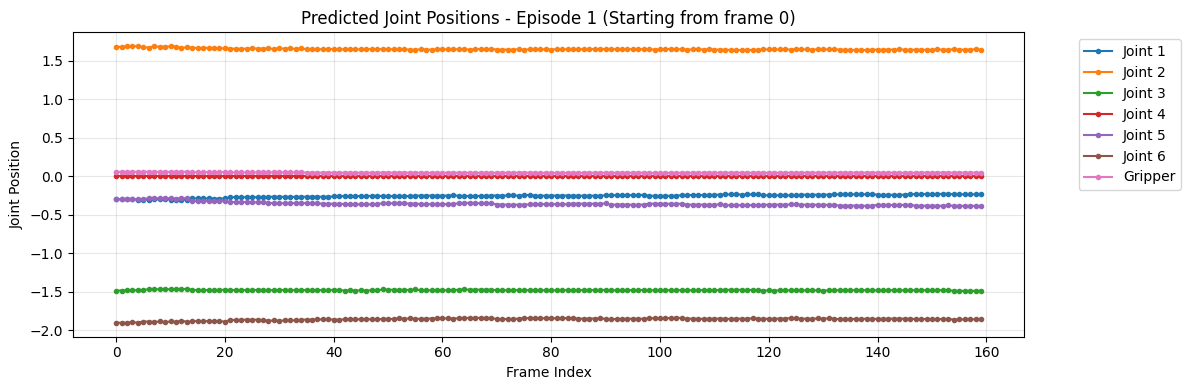

Frames plotted: 219 (from index 0 to 218)


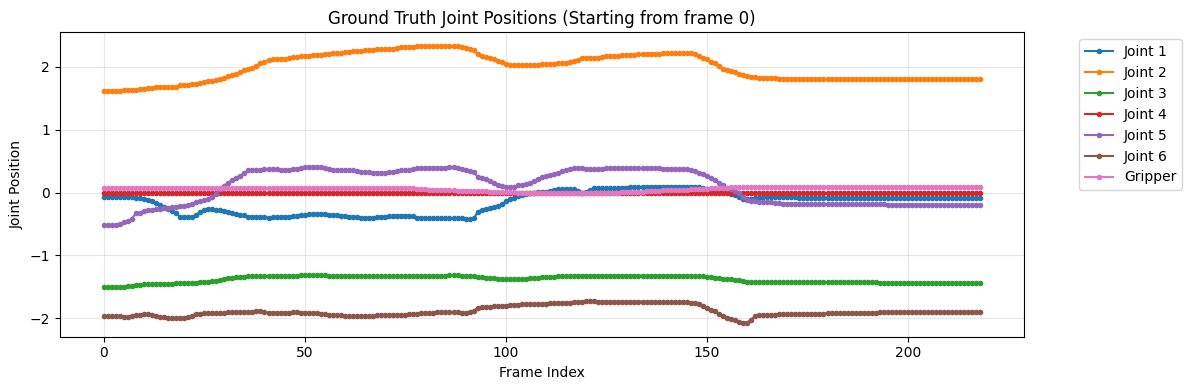

In [2]:
!python extract_joint_positions.py

import json
import matplotlib.pyplot as plt
import numpy as np

def plot_joint_positions(json_file_path, title, start_frame_index=0):
    """
    Plots joint positions from a JSON file, starting from a specified frame index.
    Handles both inference results format and joint positions format.

    Parameters:
    json_file_path (str): Path to the JSON file.
    title (str): Title for the plot.
    start_frame_index (int): The frame index from which to start plotting. Defaults to 0 (the beginning).
    """
    # Read the JSON file
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    
    # Check if this is inference results format (list of objects with 'result' key)
    # or joint positions format (list of arrays)
    if isinstance(data, list) and len(data) > 0:
        # This is joint positions format (list of arrays)
        # For this format, we'll just plot all data starting from start_frame_index
        if start_frame_index >= len(data):
            print(f"No data found starting from frame index {start_frame_index}.")
            return
        
        # Extract joint positions from start_frame_index onward
        filtered_data = data[start_frame_index:]
        frame_indices = list(range(start_frame_index, start_frame_index + len(filtered_data)))
        print(f"Frames plotted: {len(frame_indices)} (from index {min(frame_indices)} to {max(frame_indices)})")
        
        # Initialize lists for each joint
        joints = [[] for _ in range(7)]  # 6 joints + 1 gripper
        
        # Extract joint positions for each frame in the filtered data
        for action in filtered_data:
            for i in range(7):  # 6 joints + 1 gripper
                joints[i].append(action[i])

    
    # Create the plot
    plt.figure(figsize=(12, 4)) # Slightly larger figure for clarity
    
    # Joint names
    joint_names = ['Joint 1', 'Joint 2', 'Joint 3', 'Joint 4', 'Joint 5', 'Joint 6', 'Gripper']
    
    # Plot each joint with a different color
    for i in range(7):
        plt.plot(frame_indices, joints[i], label=joint_names[i], marker='o', markersize=3, linewidth=1.5)
    
    # Add labels and title
    plt.xlabel('Frame Index')
    plt.ylabel('Joint Position')
    plt.title(f"{title} (Starting from frame {start_frame_index})")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Legend outside plot
    plt.grid(True, alpha=0.3)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

plot_joint_positions('temp/inference_actions.json', 'Predicted Joint Positions - Episode 1')
plot_joint_positions('temp/metadata_20251113_080958_gt.json', 'Ground Truth Joint Positions')


In [ ]:
from pathlib import Path
from lerobot.policies.diffusion.modeling_diffusion import DiffusionPolicy
output_directory = Path("outputs/eval/example_pusht_diffusion")
# Comment out the old pretrained model path
 # pretrained_policy_path = "lerobot/diffusion_pusht"
# Use your newly trained model path instead
pretrained_policy_path = Path("outputs/train/example_pusht_diffusion")
policy = DiffusionPolicy.from_pretrained("ISdept/piper_arm")

print(policy.config)

In [ ]:
# Updated plotting functionality using the new plotting utility
import sys
from pathlib import Path
sys.path.append(str(Path().resolve()))

from plotting_utils import plot_joint_positions

# Plot the data using the improved function that handles both file formats
plot_joint_positions('temp/inference_actions.json', 'Predicted Joint Positions - Episode 1')
plot_joint_positions('temp/metadata_20251113_080958_gt.json', 'Ground Truth Joint Positions')

In [ ]:
!python inspect_local_parquet.py